This project largely serves as a means for me to look at my Spotify music listening statistics and to identify trends and undertand how my taste in music has changed over time.
It has been set up such that anyone could use it by loading their own listening statistics from Spotify.  

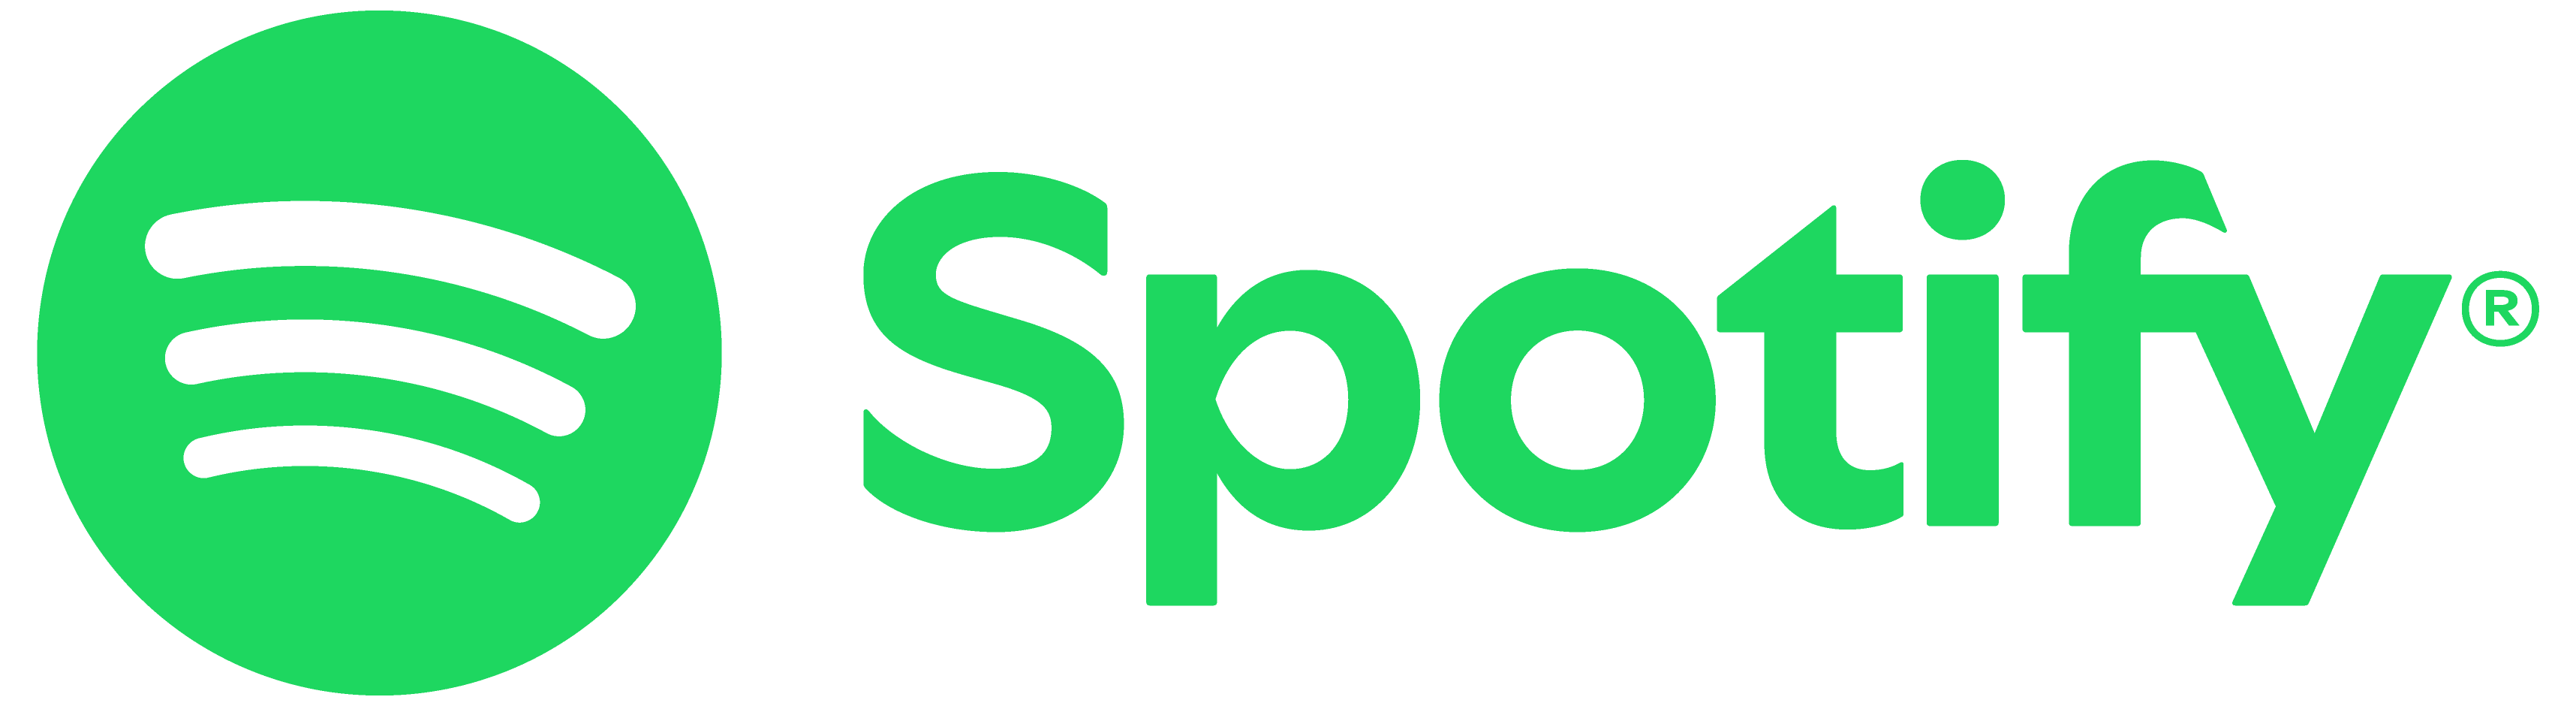

Image Source: https://newsroom.spotify.com/media-kit/logo-and-brand-assets/

In [1]:
import pandas as pd
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina" #higher quality graphs

import time
start_time = time.time()

In [2]:
#importing .json files containing Spotify usage data
file_list = glob.glob('/content/drive/MyDrive/Coding/Spotify Extended Streaming History/*.json')

#file_list = glob.glob('/Users/oneshpunchinilame/Desktop/Spotify Extended Streaming History/*.json')

data_frames = []
for file in file_list:
  data_frames.append(pd.read_json(file))

In [3]:
#Storing all the read-in files in one dataframe
dataframe = pd.concat(data_frames)
original_data = dataframe #Preserving original data

Initial Inspection of the data

In [4]:
dataframe.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')

Columns such as "ip_addr" and "platform" are not relevant for the purpose of this analysis. Furthermore, columns relating to podcasts and audiobooks will also be dropped as it's the music playtime statistics that we are looking for.

Inspecting for any missing data

In [5]:
dataframe.isnull().sum()

,0
ts,0
platform,0
ms_played,0
conn_country,0
ip_addr,0
master_metadata_track_name,277
master_metadata_album_artist_name,277
master_metadata_album_album_name,277
spotify_track_uri,277
episode_name,285415


There's plenty of missing values but mostly in the columns we are uninterested in.

## Data Cleaning

In [6]:
#Removing irrelevant columns
dataframe = dataframe.drop(columns=['platform', 'conn_country', 'ip_addr',
                                     'episode_name', 'audiobook_title', 'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
                                    'episode_show_name', 'spotify_episode_uri', 'incognito_mode',
                                    'skipped', 'reason_end', 'offline', 'offline_timestamp', 'reason_start', 'shuffle'])


In [7]:
dataframe.isna().sum()

,0
ts,0
ms_played,0
master_metadata_track_name,277
master_metadata_album_artist_name,277
master_metadata_album_album_name,277
spotify_track_uri,277


In [8]:
dataframe.notna().sum()

,0
ts,285692
ms_played,285692
master_metadata_track_name,285415
master_metadata_album_artist_name,285415
master_metadata_album_album_name,285415
spotify_track_uri,285415


As the amount of missing data accounts for less than 1% of the total data, these values will be removed and its impact on the analysis should be negligible.

In [9]:
#Preserving the removed values in case it needs to be referred to later
dropped_rows = dataframe[dataframe["master_metadata_track_name"].isnull()]
dataframe.dropna(inplace=True)

In [10]:
dataframe.head()

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri
0,2019-11-20T15:00:06Z,254049,Kids in Love (feat. The Night Game),Kygo,Kids in Love,spotify:track:5nmHl233yo8XJvaNfdKAWU
1,2019-11-20T15:00:06Z,865,Orphans,Coldplay,Orphans / Arabesque,spotify:track:6muOWhMh7Tf0UFUtMDBhUR
2,2019-11-20T15:00:06Z,2303,The Reason,Hoobastank,The Reason,spotify:track:77loZpT5Y5PRP1S451P9Yz
3,2019-11-20T15:00:06Z,6874,Orphans,Coldplay,Orphans / Arabesque,spotify:track:6muOWhMh7Tf0UFUtMDBhUR
4,2019-11-20T15:00:06Z,184360,This Town (feat. Sasha Alex Sloan),Kygo,Stargazing - EP,spotify:track:4aSfgWmRa9KsISD4Jmx7QB


The "ts" column can converted to two columns containing the date and time respectively, for ease of access.  The spotify_track_uri column can be cleaned to remove the repeating element "spotify:track:" as it is redundant.

In [11]:
#Converting the "ts" column into datetime
dataframe["Date/Time"] = pd.to_datetime(dataframe["ts"])

In [12]:
#Seperating the dates and time into more accessible values
dataframe["Date"] = pd.to_datetime(dataframe["Date/Time"].dt.date)
#dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe["Time"] = dataframe["Date/Time"].dt.time
dataframe["Year"] = dataframe["Date/Time"].dt.year
dataframe["Month"] = dataframe["Date/Time"].dt.month

In [13]:
# Dropping "ts" column as the data is contained in the "Date" and "Time" columns
dataframe = dataframe.drop(columns = ["ts", "Date/Time"])

In [14]:
#Removing the leading string "spotify:track:" in the "spotify_track_uri"
dataframe["spotify_track_uri"] = dataframe["spotify_track_uri"].astype(str)
dataframe["spotify_track_uri"] = dataframe["spotify_track_uri"].map(lambda x: x.lstrip('spotify:track:'))

In [15]:
#Renaming columns for ease of usage
dataframe = dataframe.rename(columns = {"master_metadata_track_name":"Track_name","master_metadata_album_artist_name":"Artist", "master_metadata_album_album_name":"Album"})

In [16]:
dataframe.sort_values(['Date', 'Time'], inplace=True) #Arranging the dataset in ascending order of the date and time

dataframe.tail(1) #Inspecting the final entry in the dataset

,ms_played,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month
3861,645,Gabriela,KATSEYE,Gabriela,1xOqGUkyxGQRdCvGpvWKmL,2025-10-12,23:56:58,2025,10


The last input in the dataframe is dated at 12th of October, 2025. The analysis for the listening trends in 2025 can only be conducted upto this date.

In [17]:
dataframe.shape

(285415, 9)

Sometimes, Artists tend to stylize their names by using `$` to denote an 's'. This could be a problem later on so we will replace `$` with an 's'

In [18]:
dataframe[dataframe["Artist"].str.contains('\\$')].count()

,0
ms_played,1634
Track_name,1634
Artist,1634
Album,1634
spotify_track_uri,1634
Date,1634
Time,1634
Year,1634
Month,1634


There are 1,634 entries with an Artist who has stylised their name in the aforementioned way.

In [19]:
#Replacing '$' with 's'

dataframe["Artist"] = dataframe['Artist'].str.replace(r'$', 's')

dataframe[dataframe["Artist"].str.contains('\\$')].count() #Confirming the replacement was successful

,0
ms_played,0
Track_name,0
Artist,0
Album,0
spotify_track_uri,0
Date,0
Time,0
Year,0
Month,0


In [20]:
print(dataframe['ms_played'].min())
dataframe[dataframe['ms_played'] == 0].count()

0


,0
ms_played,18558
Track_name,18558
Artist,18558
Album,18558
spotify_track_uri,18558
Date,18558
Time,18558
Year,18558
Month,18558


There are over 18,000 entries where the track has registered a playtime of 0 ms. As this provides no real insight into the listening trends, these entries will be removed to another dataframe for reference.

In [21]:
dataframe["ms_played"][dataframe['ms_played'] < 1000].count()

np.int64(54821)

Furthermore, there are over 54,000 tracks with a playtime of less than 1 second. These values will also be removed and preserved as they do not add any insight into the listening trends.

In [22]:
dataframe_less_than_1s = dataframe[dataframe['ms_played'] < 1000]
dataframe = dataframe[dataframe['ms_played'] >= 1000]

In [23]:
#Inspecting for duplicated values
dataframe[dataframe.duplicated()].count()

,0
ms_played,4305
Track_name,4305
Artist,4305
Album,4305
spotify_track_uri,4305
Date,4305
Time,4305
Year,4305
Month,4305


In [24]:
dataframe[dataframe.duplicated].sort_values(["Track_name","Artist" ,"Date", "Time"])

,ms_played,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month
3910,207440,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-11,18:17:24,2018,12
13972,1215,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2020-08-23,18:55:13,2020,8
3883,96044,(I Just) Died In Your Arms,Cutting Crew,The Best Of Cutting Crew,0YPXkQthLWrhNGoKTbwCJ8,2018-12-11,18:17:24,2018,12
12130,6944,(I Just) Died In Your Arms,Cutting Crew,The Best Of Cutting Crew,0YPXkQthLWrhNGoKTbwCJ8,2021-06-26,11:35:33,2021,6
10005,178173,1+1,Sia,Music,71Taskl2O73XfpQtJciJCD,2022-01-13,07:16:54,2022,1
...,...,...,...,...,...,...,...,...,...
4453,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-22,16:26:52,2021,10
4877,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10
4932,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10
4944,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10


There are over 4,000 duplicate entries in the dataframe. These will need to be removed.

In [25]:
#Inspecting Dataset to ensure all duplicate values have been accounted for
dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].sort_values(["Track_name", "Date", "Time"])

,ms_played,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month
3910,207440,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-11,18:17:24,2018,12
4549,1272,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-18,15:16:15,2018,12
4607,164064,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-18,15:16:15,2018,12
7385,1692,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2019-01-22,14:32:05,2019,1
13972,1215,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2020-08-23,18:55:13,2020,8
...,...,...,...,...,...,...,...,...,...
4799,2784,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10
4877,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10
4932,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10
4944,210219,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10


However, by omitting the "ms_played" column in the search for duplicates, there appear to be 4,000 more entries which have the same spotify_track_id, Artist, Date, and Time for at least one entry in the dataframe. If the timestamps are accurate, it's impossible that "ms_played" column registered multiple legitimate values for the same timestamp. These values must have been recorded in error and will be removed.

In [26]:
print(dataframe.shape) #Viewing the shape of dataframe to reference once removal of duplicate rows is complete

(230594, 9)


In [27]:
#Preserving the duplicated rows
duplicated_rows = dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].sort_values(["Track_name", "Date", "Time"])
print(duplicated_rows.shape)

#Removing duplicates
dataframe = dataframe.drop_duplicates(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])
print(dataframe.shape)

(8400, 9)
(222194, 9)


In [28]:
#Confirming that all duplicate values have been removed
dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ms_played          0 non-null      int64         
 1   Track_name         0 non-null      object        
 2   Artist             0 non-null      object        
 3   Album              0 non-null      object        
 4   spotify_track_uri  0 non-null      object        
 5   Date               0 non-null      datetime64[ns]
 6   Time               0 non-null      object        
 7   Year               0 non-null      int32         
 8   Month              0 non-null      int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(5)
memory usage: 0.0+ bytes


All duplicated values have been removed.

## Creating Dataframes for Analysis

### Dataframes

In [29]:
print(dataframe.duplicated(["Track_name"]).sum())

206053


There are over 200,000 songs that share the same track_name (they aren't necessarily by the same artists) in the dataframe. For example:

In [30]:
dataframe[dataframe["Track_name"] == "Die For You"].groupby("Artist").count()

,ms_played,Track_name,Album,spotify_track_uri,Date,Time,Year,Month
Artist,,,,,,,,
Joji,100,100,100,100,100,100,100,100
The Weeknd,489,489,489,489,489,489,489,489


Each song has a unique ID (spotify_track_uri) that will be used to identify each track.

In [31]:
#Creating a dataframe with each unique track and the total number of minutes the respective track was played
minutes_played_per_song = dataframe.groupby("spotify_track_uri").agg(

    Minutes_Played = ("ms_played" , 'sum')
)

minutes_played_per_song.sort_values(by="Minutes_Played", ascending = False, inplace=True)
minutes_played_per_song['Minutes_Played'] = minutes_played_per_song['Minutes_Played']/(60000) #Converting milliseconds into minutes
minutes_played_per_song.reset_index(inplace=True)

In [32]:
num_of_unique_songs = pd.DataFrame()
num_of_unique_songs = dataframe.drop(columns=[ "ms_played"])

In [33]:
#Creating a df that keeps track of each time a song was played (unique date and time)

unique_track_counter = num_of_unique_songs.groupby(["spotify_track_uri"]).agg(
    No_of_Seperate_Instances = ('spotify_track_uri', 'count')
)

In [34]:
unique_track_counter.reset_index(inplace=True)
unique_track_counter.sort_values("No_of_Seperate_Instances", ascending=False, inplace=True)

In [35]:
num_of_unique_songs = unique_track_counter.merge(right=num_of_unique_songs, left_on="spotify_track_uri", right_on="spotify_track_uri")
num_of_unique_songs.drop_duplicates("spotify_track_uri", inplace=True)

In [36]:
#Changing the "Date" column to reflect the changes
num_of_unique_songs.rename(columns={"Date":"First_Played"}, inplace=True, index=None)

#DF with every unique track and the number of seperate times the song has been played
num_of_unique_songs = num_of_unique_songs.drop_duplicates(["Track_name", "Artist"])

In [37]:
num_of_unique_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18058 entries, 0 to 222193
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   spotify_track_uri         18058 non-null  object        
 1   No_of_Seperate_Instances  18058 non-null  int64         
 2   Track_name                18058 non-null  object        
 3   Artist                    18058 non-null  object        
 4   Album                     18058 non-null  object        
 5   First_Played              18058 non-null  datetime64[ns]
 6   Time                      18058 non-null  object        
 7   Year                      18058 non-null  int32         
 8   Month                     18058 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(5)
memory usage: 1.2+ MB


In [38]:
num_of_unique_songs = num_of_unique_songs.merge(minutes_played_per_song,
                                                left_on="spotify_track_uri", right_on="spotify_track_uri")

#Adding the playtime of each track (Minutes_Played) to num_of_unique_songs df
num_of_unique_songs.sort_values(by="Minutes_Played", ascending=False, inplace=True)

Creating a dataframe where the listening time is categorized by artists (artist_tracker)


In [39]:
artist_tracker = num_of_unique_songs.groupby('Artist').agg(
    Minutes = ('Minutes_Played', 'sum'),
)
artist_tracker["Hours"] = artist_tracker["Minutes"]/60
artist_tracker["Days"] = artist_tracker["Hours"]/(24)
artist_tracker.sort_values(by='Minutes', ascending=False, inplace=True) #Ordering the dataset from the most minutes played to the least
artist_tracker.reset_index(inplace=True)
artist_tracker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6389 entries, 0 to 6388
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   6389 non-null   object 
 1   Minutes  6389 non-null   float64
 2   Hours    6389 non-null   float64
 3   Days     6389 non-null   float64
dtypes: float64(3), object(1)
memory usage: 199.8+ KB


There are over 6,000 entries in the artist_tracker df.

In [40]:
artist_tracker.head(20)["Minutes"].median()

4227.826883333333

The top twenty artists in the dataset have a median of 4228 minutes

In [41]:
artist_tracker[artist_tracker["Minutes"] < 30].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5504 entries, 885 to 6388
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   5504 non-null   object 
 1   Minutes  5504 non-null   float64
 2   Hours    5504 non-null   float64
 3   Days     5504 non-null   float64
dtypes: float64(3), object(1)
memory usage: 215.0+ KB


There are over 5,000 artists with a total playtime of less than 30 minutes. For this analysis, we will seperate the dataset on this metric, while largely focusing only on artists who have a total playtime of at least 30 minutes.

In [42]:
artist_tracker_removed = artist_tracker[artist_tracker["Minutes"] < 30] #Preserving the removed entries for later reference
artist_tracker = artist_tracker[artist_tracker["Minutes"] >= 30]

In [43]:
#Dataframe with listening times for each artist per year

artist_years = dataframe.groupby(["Artist", "Year"]).agg(
    Minutes = ('ms_played', 'sum'),
    Times_listened = ('Artist', 'count')
)
artist_years['Minutes'] = artist_years['Minutes']/60000 #Converting milliseconds to minutes
artist_years.insert(len(artist_years.columns), "Hours", artist_years["Minutes"]/60)
artist_years.sort_values(by='Minutes', ascending=False, inplace=True)
artist_years.reset_index(inplace=True)
artist_years = artist_years.reindex(columns = ["Artist", "Times_listened", "Minutes", "Hours", "Year"])

looping_dict = {}        #Empty dictionary where the df (containing artists and their playtime for each year) will be stored, with the year as key

for num in range(2018,2026):
  artist_year =  artist_years[artist_years["Year"] == num]
  artist_year.reset_index(drop=True, inplace=True)
  looping_dict[num] = artist_year

In [44]:
#Saving the playtime for artists in a year in indiviual dataframes for each year

artist_2018 = looping_dict[2018]
artist_2019 = looping_dict[2019]
artist_2020 = looping_dict[2020]
artist_2021 = looping_dict[2021]
artist_2022 = looping_dict[2022]
artist_2023 = looping_dict[2023]
artist_2024 = looping_dict[2024]
artist_2025 = looping_dict[2025]

In [45]:
# Creating a single dataframe that contains the top 10 artists of every year

top10_each_year = []

for i in range(2018, 2026):
  top10_each_year.append(looping_dict[i][0:10])

top_10_all = pd.concat(top10_each_year)
top_10_all.reset_index(drop=True, inplace=True)

In [46]:
#Dataframe containing total music listening times by month

playtime_by_month = dataframe.groupby(['Year','Month']).agg(
    Total_ms = ('ms_played', 'sum')
)
playtime_by_month['Total_Minutes'] = playtime_by_month['Total_ms']/60000
playtime_by_month.drop(columns="Total_ms", inplace=True)
playtime_by_month.reset_index(inplace=True)

In [47]:
# Dataframe containing the total number of music playtime per year

listening_by_year = artist_years.groupby("Year").agg(
    Total_Minutes = ('Minutes', 'sum'),
    Total_Hours = ('Hours', 'sum')
)
listening_by_year.reset_index( inplace=True)
listening_by_year['Cumulative_Total_Hours'] = listening_by_year['Total_Hours'].cumsum()

total_hours = int(listening_by_year['Cumulative_Total_Hours'][len(listening_by_year) - 1])


In [48]:
# Dataframe with the total hours of playtime per artist

artist_total_hours  = artist_years.groupby('Artist').agg(Total_Minutes = ('Minutes', 'sum'),Total_Hours = ('Hours', 'sum'))
artist_total_hours.sort_values('Total_Minutes',ascending=False, inplace=True)
artist_total_hours.reset_index(inplace=True)
artist_total_hours["Percentage of Total Hours"] = ((artist_total_hours["Total_Hours"]/total_hours)*100).round(2)

artist_total_hours_top15 = artist_total_hours[0:15]

In [49]:
#Dataframe with the top 5 artists per month

monthly_top5_artists = dataframe.groupby(["Artist", "Month", "Year"]).agg(
    Minutes = ('ms_played', 'sum')
)
monthly_top5_artists["Minutes"] = monthly_top5_artists["Minutes"]/60000
monthly_top5_artists.reset_index(inplace=True)
monthly_top5_artists.sort_values("Minutes", ascending=False, inplace=True)

In [50]:
#Dataframe with top 5 songs per month

monthly_top5_tracks = dataframe.groupby(['Track_name', 'Artist', 'Month', 'Year']).agg(
    Minutes = ('ms_played', 'sum')
)
monthly_top5_tracks["Minutes"] = monthly_top5_tracks["Minutes"]/60000
monthly_top5_tracks.reset_index(inplace=True)
monthly_top5_tracks.sort_values(['Month', 'Year', 'Minutes'], ascending=False, inplace=True)

### Functions

In [51]:
#To determine and plot the top 10 artists for a particular year

def top_10(artist_and_year):
  year = artist_and_year["Year"][0]
  top_10_df = artist_and_year[["Artist", "Times_listened", "Minutes", "Hours"]][0:10]
  top_10_df[["Minutes", "Hours"]] = top_10_df[["Minutes", "Hours"]].round(1)

  plt.barh(y=top_10_df['Artist'], width=top_10_df["Hours"])
  plt.xlabel("Hours")
  plt.title("Top 10 Artist's Playtimes in Hours in {}".format(year))
  plt.tick_params(direction='out')
  sns.set_style("darkgrid")
  plt.show()

  print()
  print(top_10_df)

  return

In [52]:
#To plot listening times per year for a specific artist
def artist_listening_progression(data, artist_name, start_year, end_year):
  df = data[data["Artist"] == artist_name]
  ax = sns.lineplot(x=str('Year'), y=round(df["Hours"]),data=df[df["Year"] >= start_year], marker='o')
  sns.set_style("darkgrid")
  ax.set_title("Hours Listened to {} per Year".format(artist_name))
  plt.xticks(np.arange(start_year, end_year + 1, step=1))

  return

In [53]:
# To plot the listening trends of select artists over a particular time period

def over_the_years (start_year, end_year, artists):
    artist_by_years_custom = artist_years[artist_years['Year'] >= start_year]
    artist_by_years_custom = artist_by_years_custom[artist_by_years_custom['Year'] <= end_year]
    for artist in artists:
      sns.lineplot(x='Year', y="Hours",data = artist_by_years_custom[artist_by_years_custom['Artist']== artist],
                  label=artist, marker='o')
    sns.color_palette(palette='Paired')
    sns.set_style("darkgrid")
    plt.title("Listening Trends in Hours for Artists Between {} & {}".format(start_year, end_year))
    plt.show()

In [54]:
#To plot the top 5 artists and tracks for a specific month and their shares of the monthly listening time

def top5_month(month, year):
  months = {	'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June','7':'July','8':'August','9':'September',
		      '10':'October','11':'November','12':'December'}

  t5_artists = monthly_top5_artists[(monthly_top5_artists["Year"] == year) & (monthly_top5_artists["Month"] == month)][0:5]
  t5_tracks = monthly_top5_tracks[(monthly_top5_tracks["Year"] == year) & (monthly_top5_tracks["Month"] == month)][0:5]

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  axes[0].pie(t5_artists['Minutes'], labels=t5_artists['Artist'], autopct='%1.1f%%')
  axes[0].set_title('Top 5 Artists', y=1.1)
  axes[0].axis('equal')

  bars = axes[1].barh(data=t5_tracks, y='Track_name', width='Minutes', color='#0f86b2')
  axes[1].set_title('Top 5 Tracks', y=1.1, loc='left')
  axes[1].set_xlabel('Minutes')
  axes[1].yaxis.set_inverted(True)

  fig.suptitle(f'{months[str(month)]} {year}')
  sns.set_theme(style='darkgrid')

  plt.tight_layout()
  plt.show()

## Data Visualization

In [55]:
sns.set_theme()

### Data By Artists

The top 5 artist with Playtime <= 1000 minutes:

                 Artist    Minutes     Hours      Days
885          Lucky Daye  29.979283  0.499655  0.020819
886      Charlotte Jane  29.644533  0.494076  0.020586
887            Tritonal  29.577150  0.492953  0.020540
888  Stanley Turrentine  29.520000  0.492000  0.020500
889              Ikioma  29.518767  0.491979  0.020499



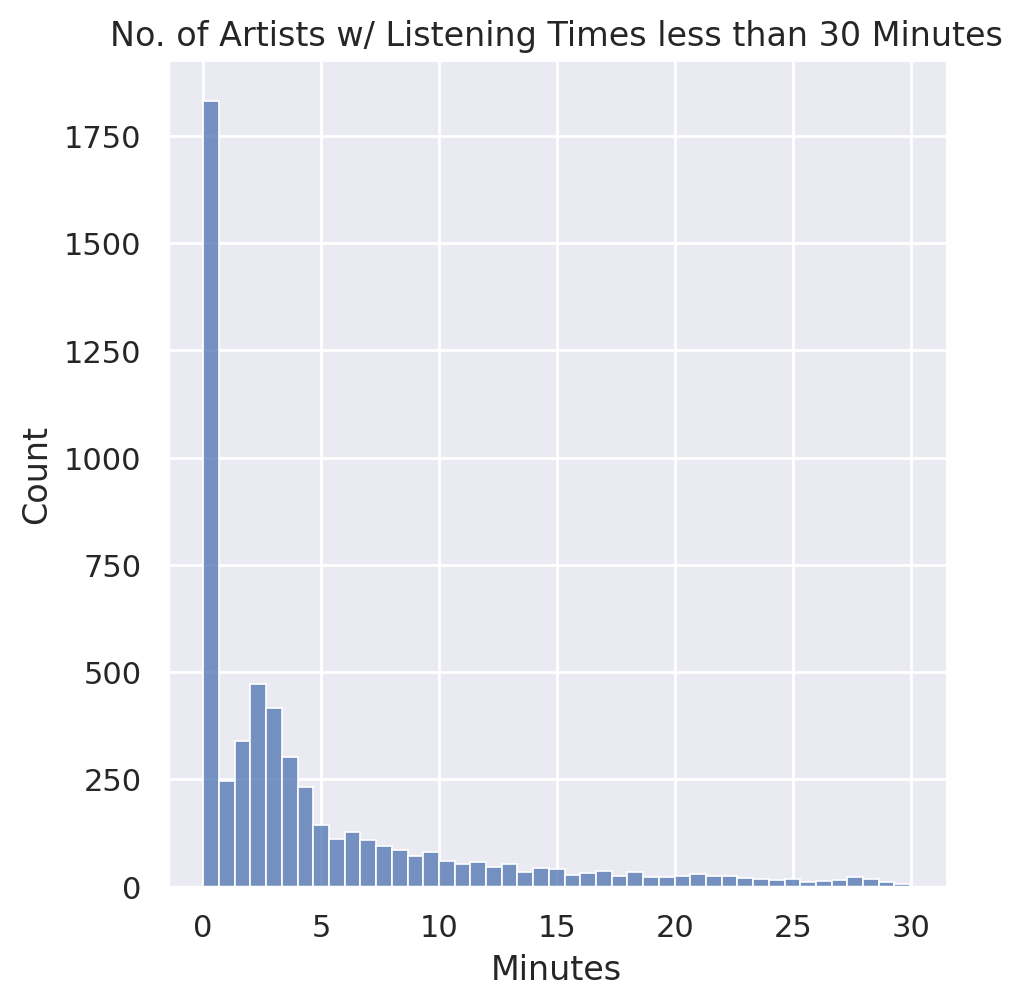

In [56]:
#Plotting the distribution of artists with a playtime less than 30 minutes

print("The top 5 artist with Playtime <= 1000 minutes:")
print()
print(artist_tracker_removed[0:5])
print()

sns.displot(artist_tracker_removed, x='Minutes')
plt.title(f"No. of Artists w/ Listening Times less than {30} Minutes")
sns.set_style('darkgrid')
plt.show()

Majority of the artist in this dataset appear to who have a total playtime of less than 5 minutes. It's clear that omitting the artist in this dataset would have a negligible impact on the overall listening analysis.

In [57]:
print(artist_tracker[artist_tracker['Minutes'] <= 1000].info())
print('-x--x--x--x--x--x-')
print(artist_tracker[artist_tracker['Minutes'] > 1000].info())

<class 'pandas.core.frame.DataFrame'>
Index: 826 entries, 59 to 884
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   826 non-null    object 
 1   Minutes  826 non-null    float64
 2   Hours    826 non-null    float64
 3   Days     826 non-null    float64
dtypes: float64(3), object(1)
memory usage: 32.3+ KB
None
-x--x--x--x--x--x-
<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   59 non-null     object 
 1   Minutes  59 non-null     float64
 2   Hours    59 non-null     float64
 3   Days     59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB
None


800+ artists have a playtime of less than or equal to 1000 minutes and 59 artists have a playtime of more than 1000 minutes. For ease of comprehension, the data will be visualized using the 1000 minute mark as well.

The top 5 artist with Playtime <= 1000 minutes:

           Artist     Minutes      Hours      Days
59     AsAP Rocky  983.077700  16.384628  0.682693
60   Clean Bandit  959.811467  15.996858  0.666536
61  The Lumineers  957.330083  15.955501  0.664813
62    Jack Harlow  955.424500  15.923742  0.663489
63         Avicii  936.892767  15.614879  0.650620



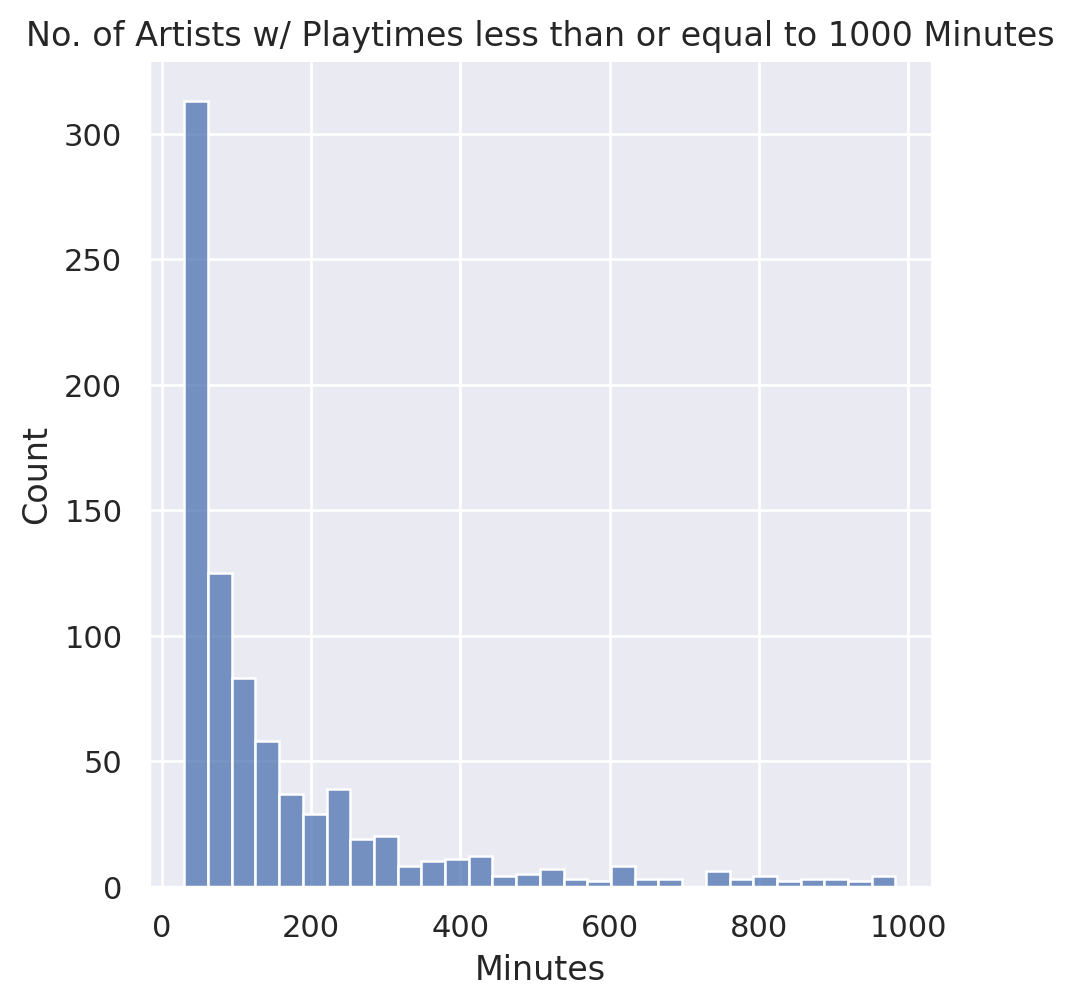

In [58]:
#Plotting the number of artists with a playtime less than or equal to a 1000 minutes
print("The top 5 artist with Playtime <= 1000 minutes:")
print()
print(artist_tracker[artist_tracker["Minutes"] <= 1000][0:5])
print()

sns.displot(artist_tracker[artist_tracker["Minutes"] <= 1000 ], x='Minutes')
sns.set_theme(style="darkgrid")
plt.title(f"No. of Artists w/ Playtimes less than or equal to {1000} Minutes")
plt.show()

The top 5 artist with Playtime > 1000 minutes:

        Artist       Minutes       Hours       Days
0   The Weeknd  50059.321333  834.322022  34.763418
1       Khalid  20822.905117  347.048419  14.460351
2         Kygo  15316.927700  255.282128  10.636755
3        Drake  14196.909050  236.615151   9.858965
4  Post Malone   7775.800600  129.596677   5.399862



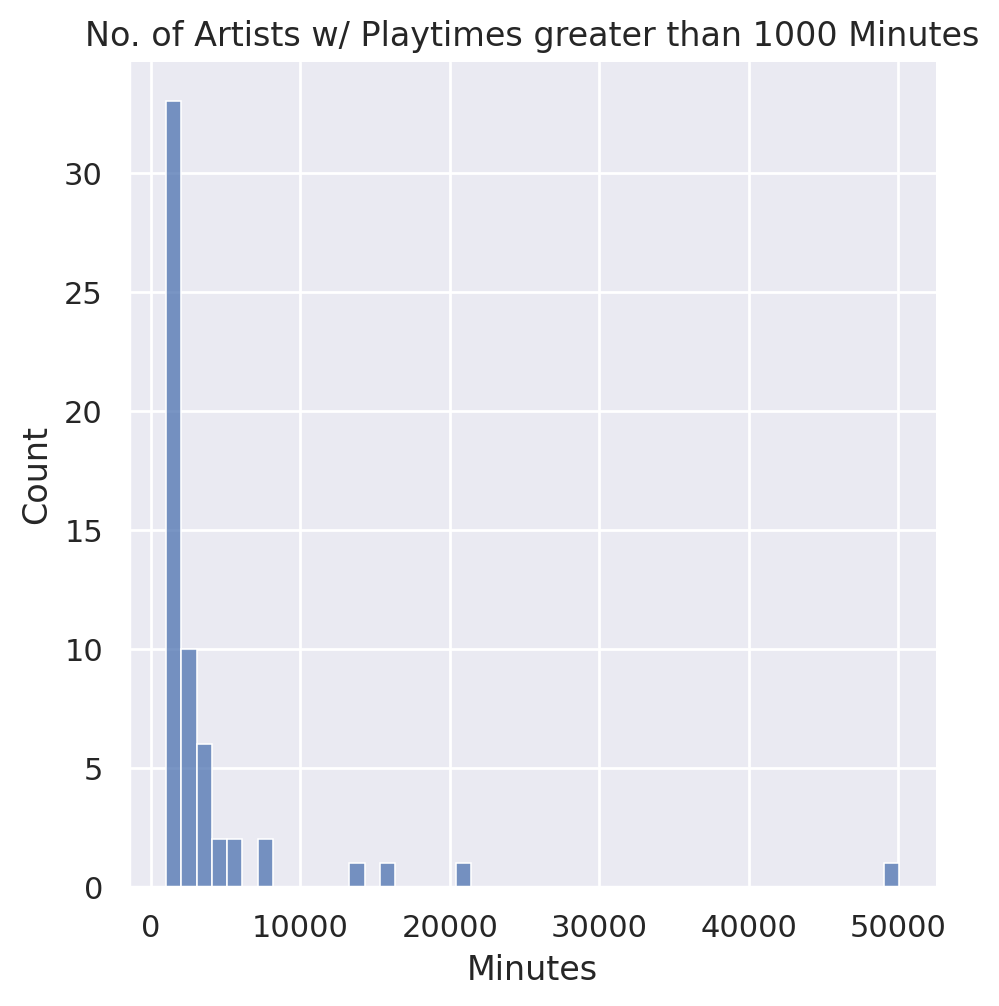

In [59]:
#Plotting the number of artists with a playtime greater than 1000 minutes
print("The top 5 artist with Playtime > 1000 minutes:")
print()
print(artist_tracker[artist_tracker["Minutes"] > 1000][0:5])
print()

sns.displot(artist_tracker[artist_tracker["Minutes"] > 1000], x='Minutes')
sns.set_theme(style="darkgrid")
plt.title(f"No. of Artists w/ Playtimes greater than {1000} Minutes")
plt.show()

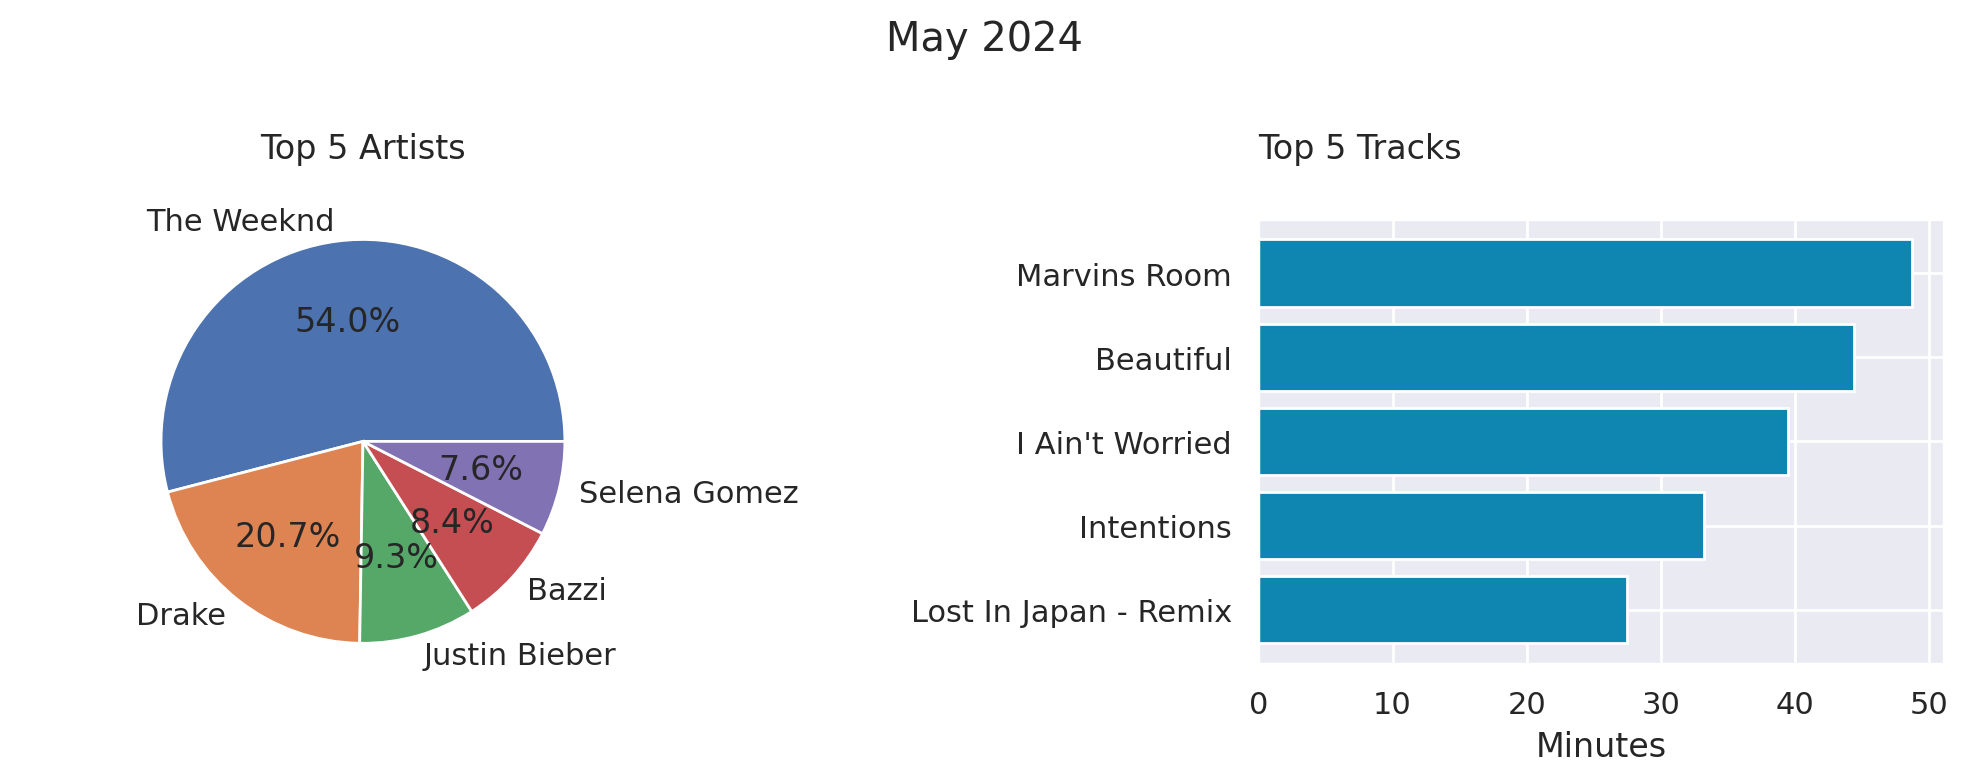

In [60]:
#Plotting the top 5 artists and tracks for a select month

top5_month(5, 2024)

### Data By Years

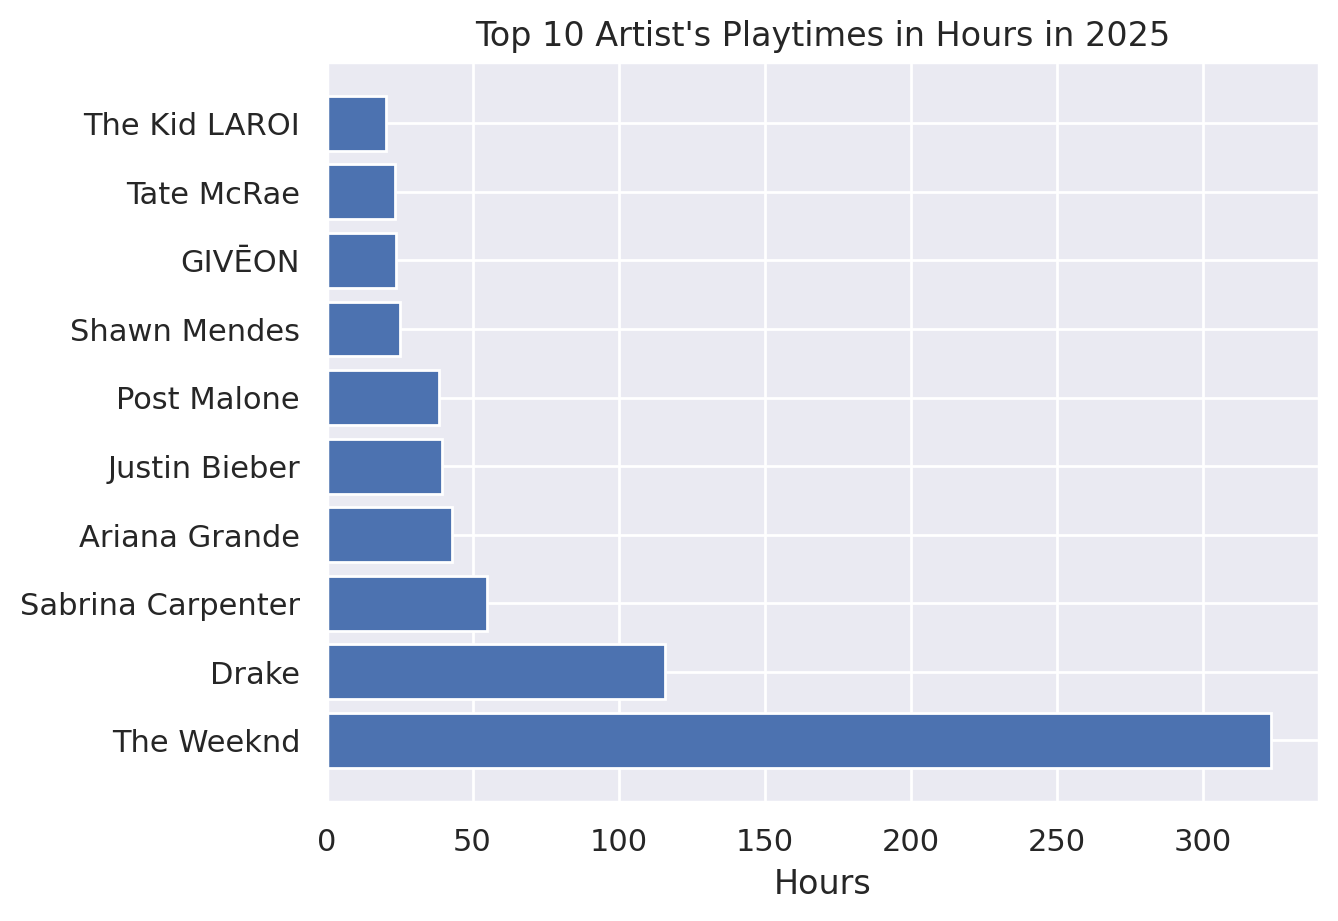


              Artist  Times_listened  Minutes  Hours
0         The Weeknd            8188  19407.9  323.5
1              Drake            3473   6956.5  115.9
2  Sabrina Carpenter            2112   3298.5   55.0
3      Ariana Grande            1605   2578.0   43.0
4      Justin Bieber            1665   2363.8   39.4
5        Post Malone            1837   2317.3   38.6
6       Shawn Mendes             876   1516.0   25.3
7             GIVĒON             883   1422.3   23.7
8         Tate McRae            1016   1397.9   23.3
9      The Kid LAROI             840   1212.0   20.2


In [61]:
#Displaying the Top 10 Artists for a select year

top_10(artist_2025)

<Figure size 1000x1000 with 0 Axes>

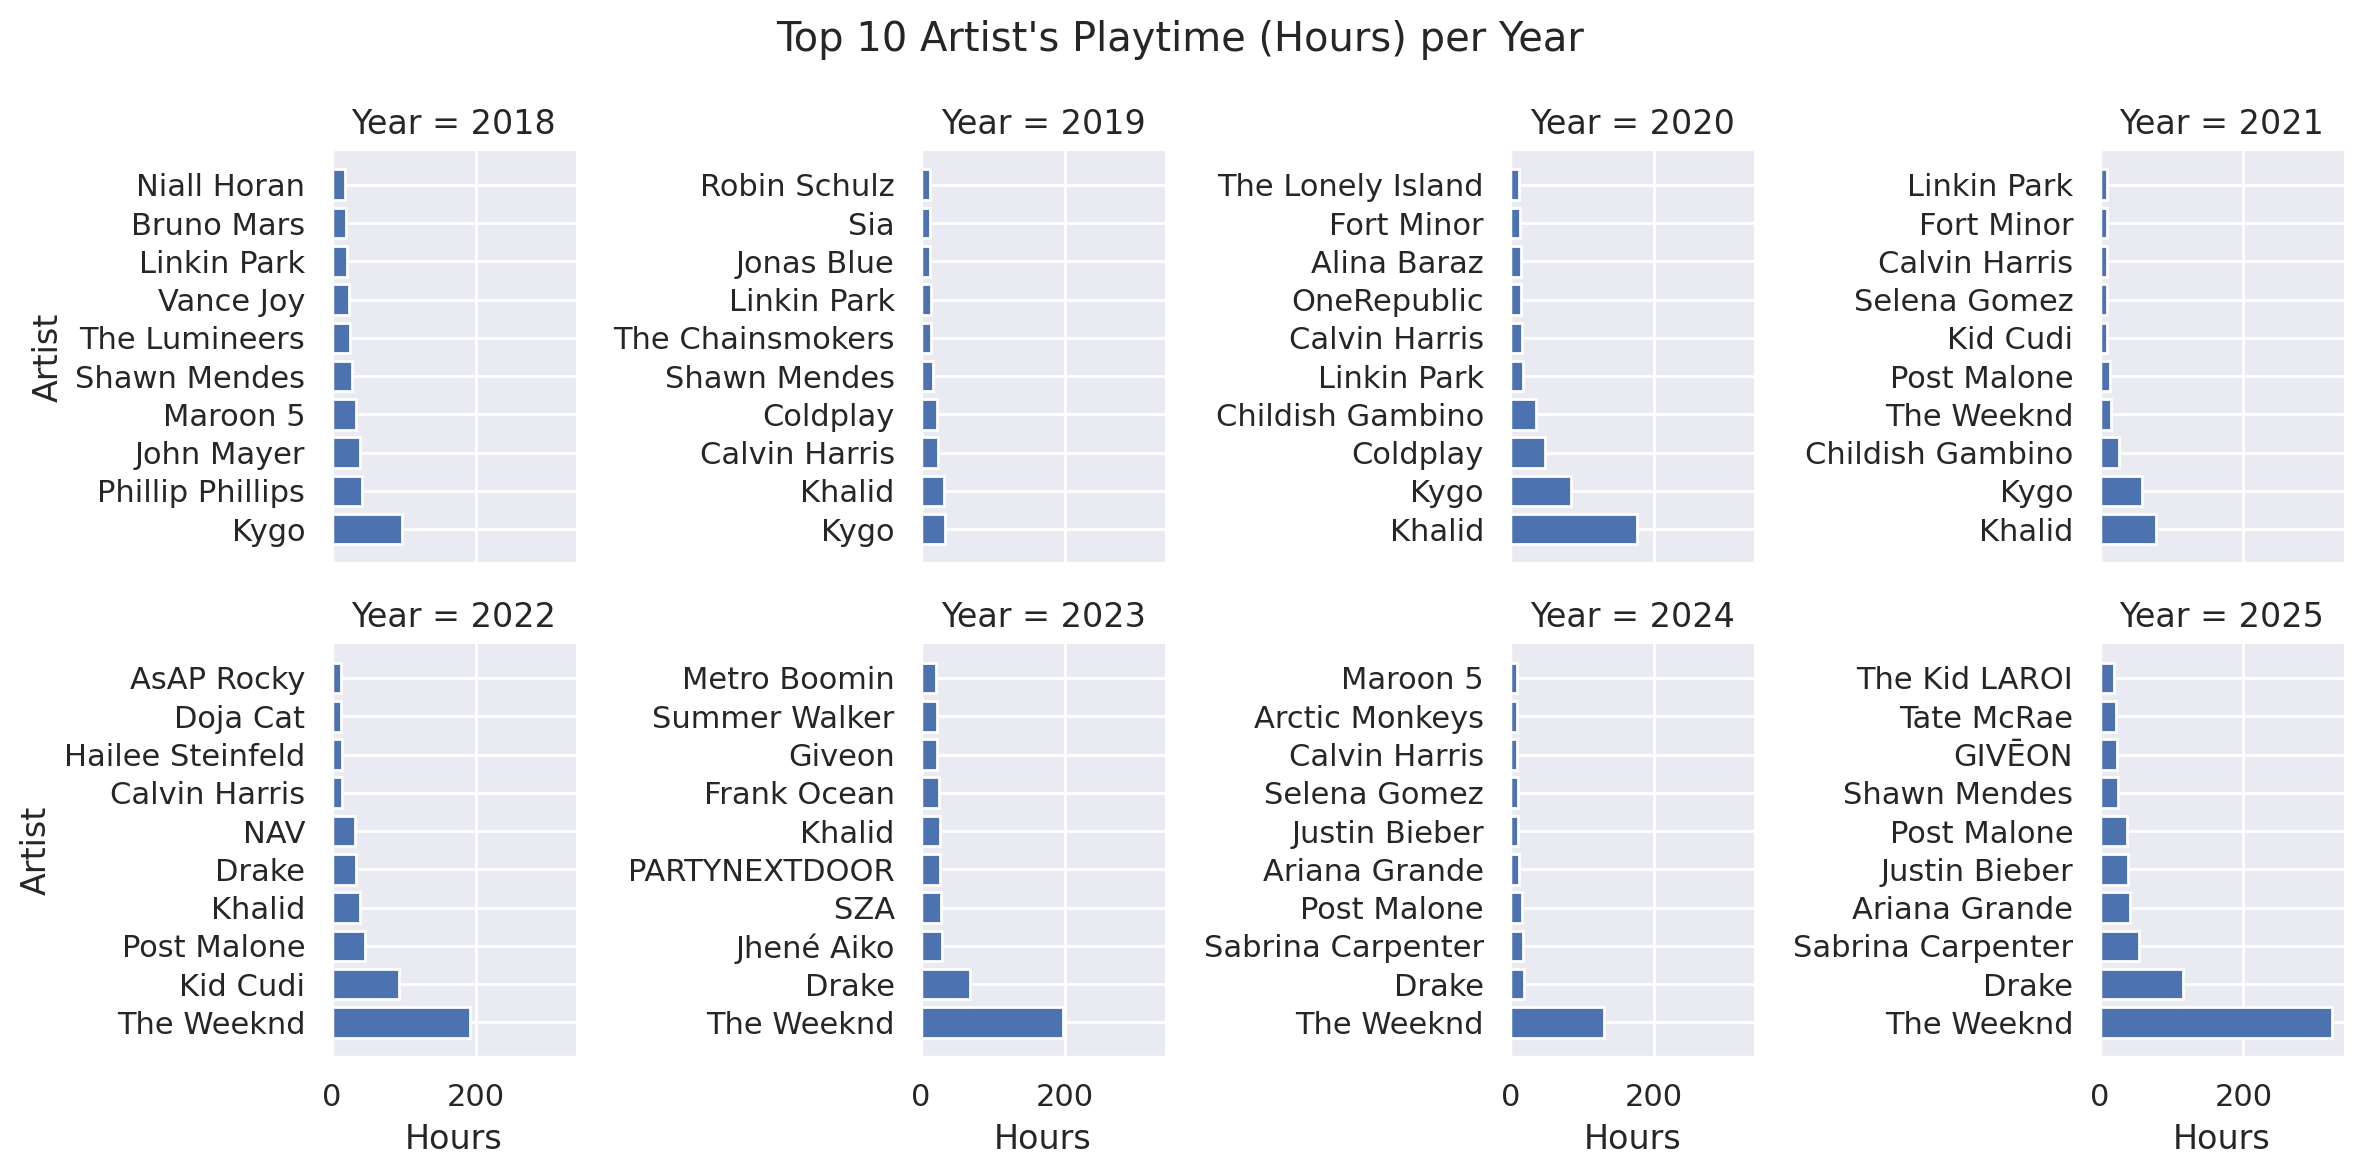

In [62]:
#Plotting my top 10 artists (according to the minutes played) for every year since 2018

a = sns.FacetGrid(data=top_10_all,col="Year",
                  sharey=False, sharex=True, col_wrap=4) #Kept the x axis common to allow for a better comparision among the years

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
a.map(plt.barh, 'Artist', 'Hours')
a.set_axis_labels(x_var='Hours', y_var='Artist')
a.fig.suptitle("Top 10 Artist's Playtime (Hours) per Year")
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

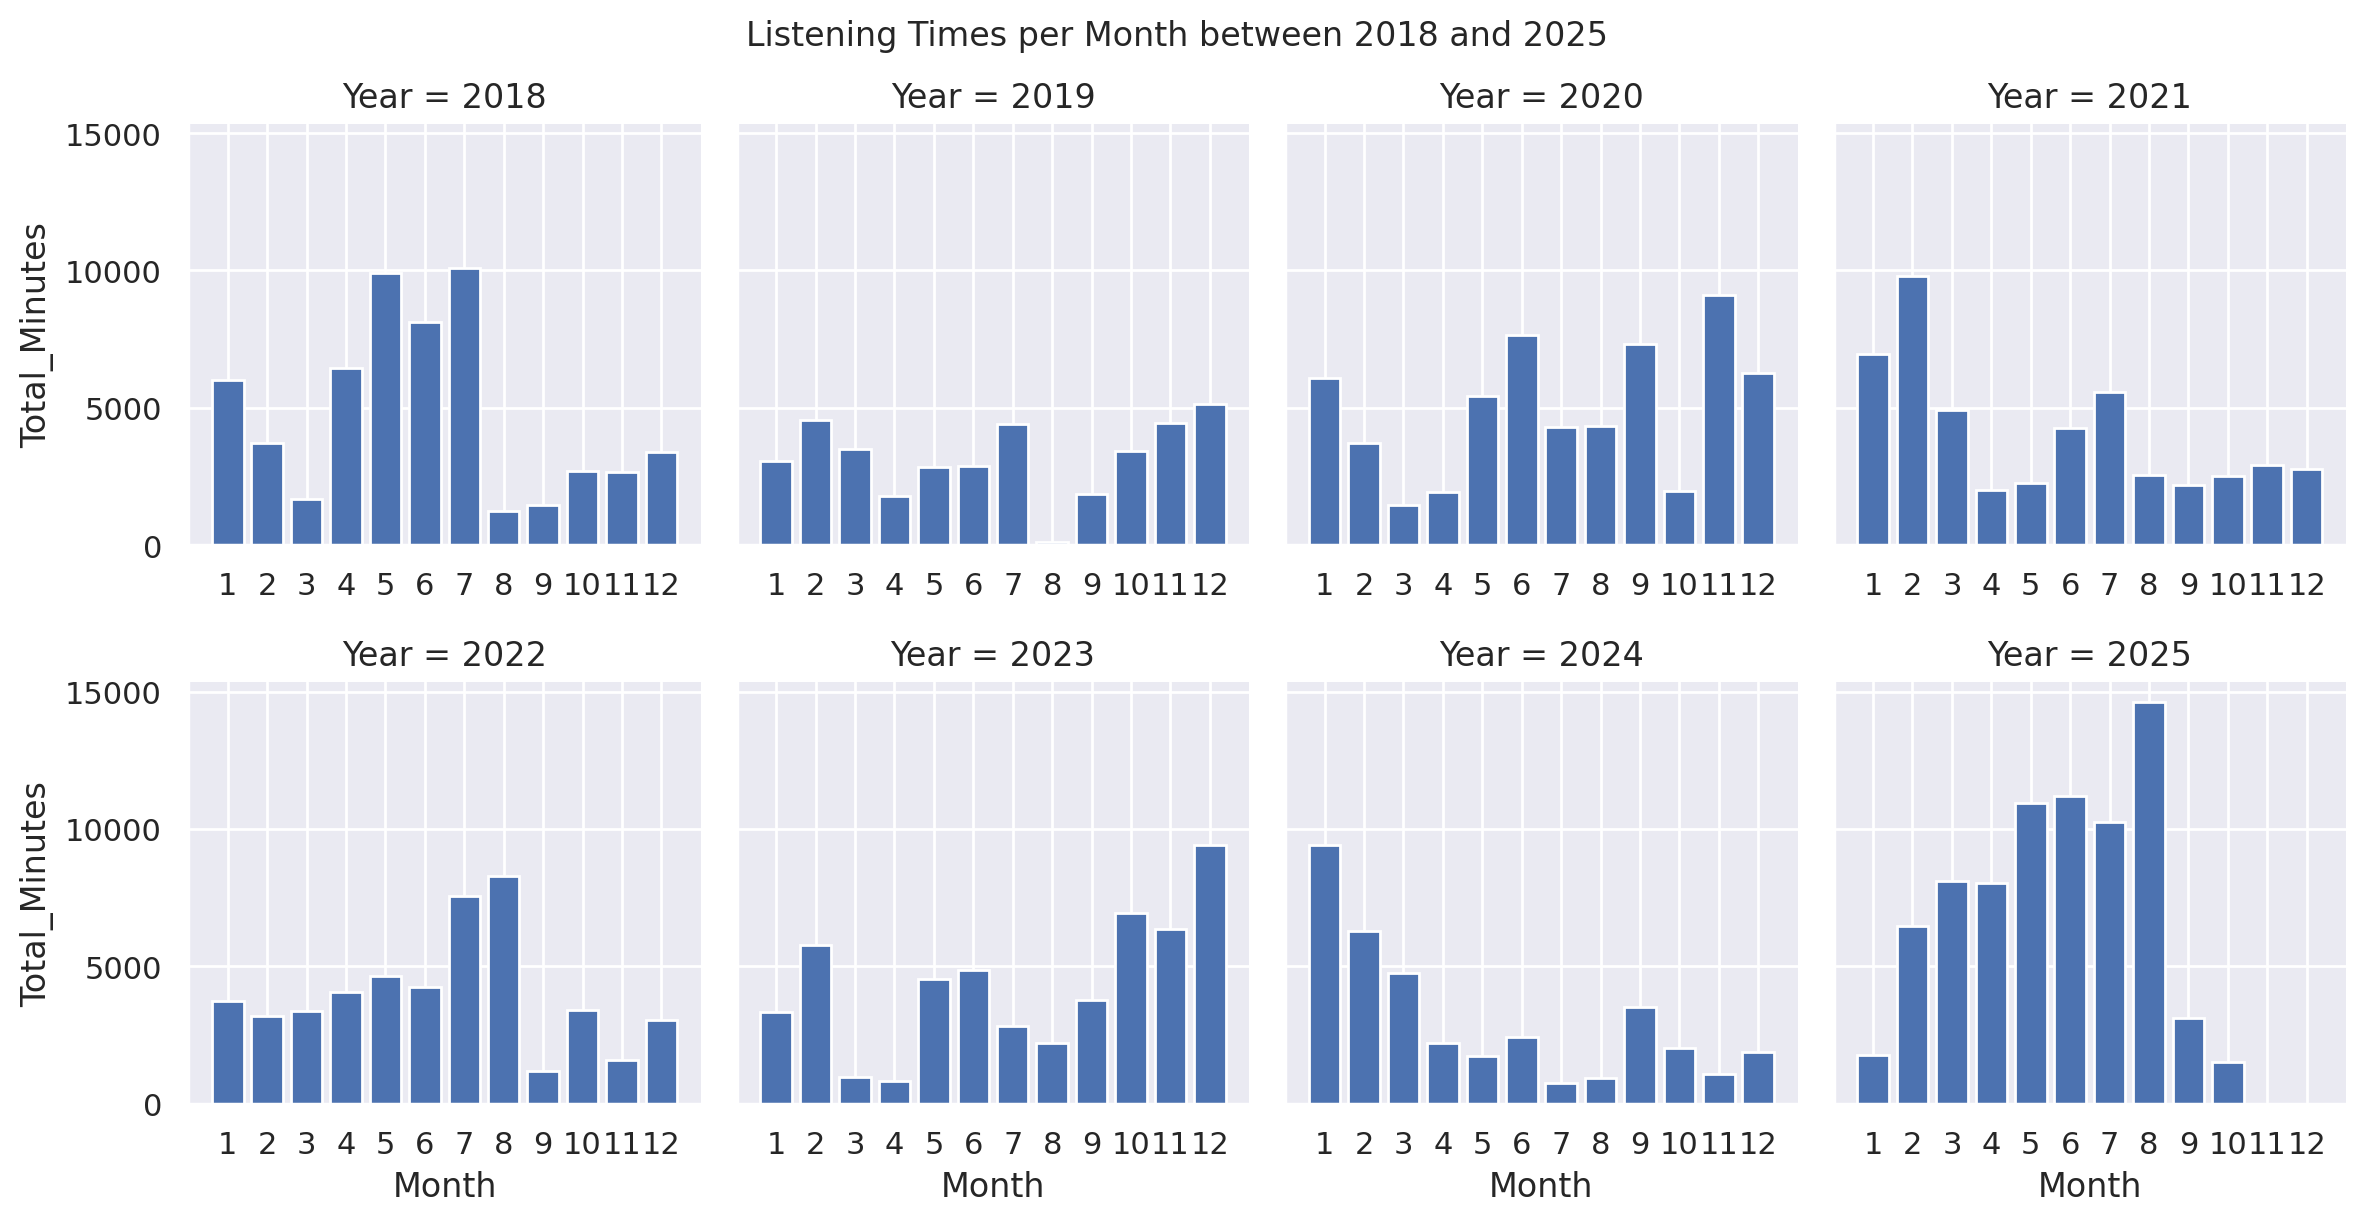

In [63]:
#Plotting my total music playtime in minutes per month for every year since 2018

plt.figure(figsize=(8,8))

b = sns.FacetGrid(playtime_by_month, col='Year', col_wrap=4, sharex=False, sharey=True)
b.map(plt.bar, 'Month', 'Total_Minutes')
b.set(xlim=(0, 13), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
b.fig.suptitle("Listening Times per Month between {} and {} ".format(playtime_by_month["Year"].min(),
                                  playtime_by_month["Year"].max()), y=1.02, size=12)

plt.show()

#### Artist Listening Progression

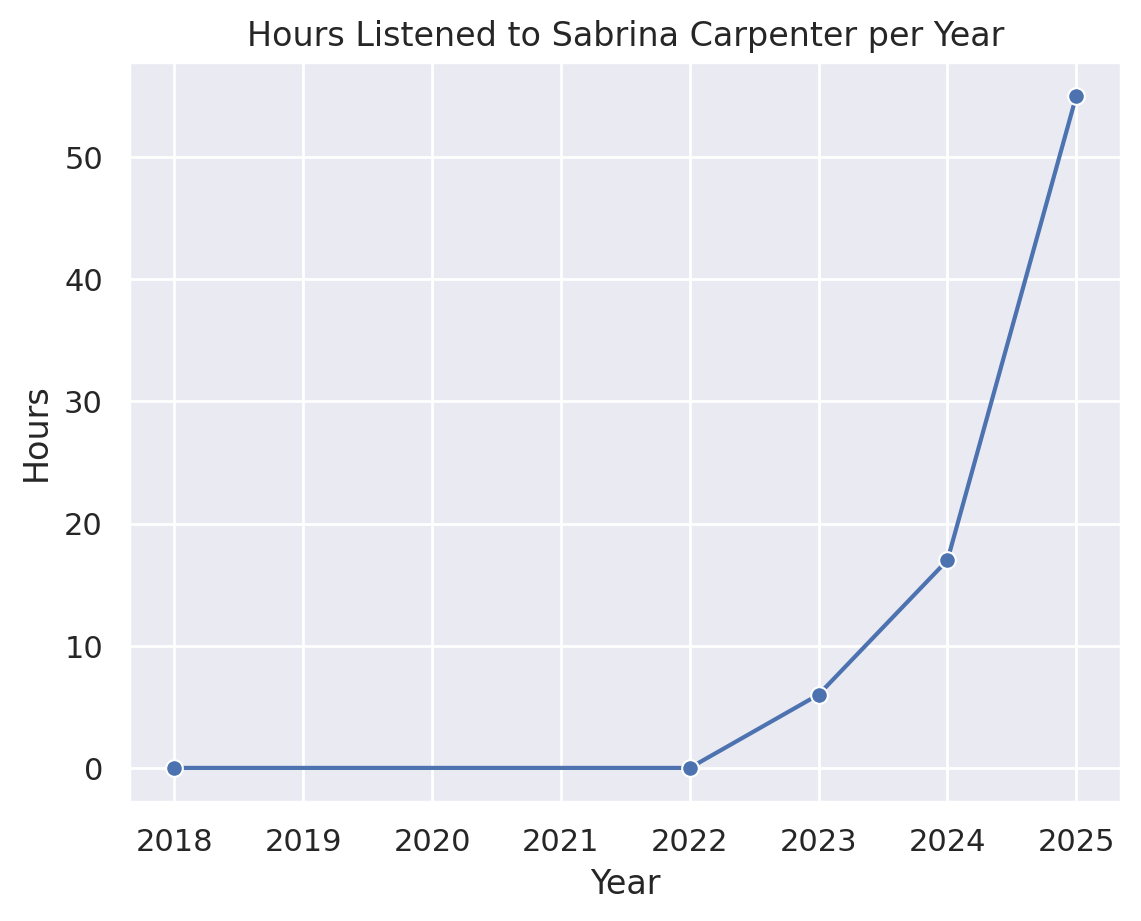

In [64]:
#Plotting the trend in my playtimes per year for a select artist

artist_listening_progression(artist_years, "Sabrina Carpenter", 2018, 2025) #Calling the artist_listening_progression function

#### Listening Trends

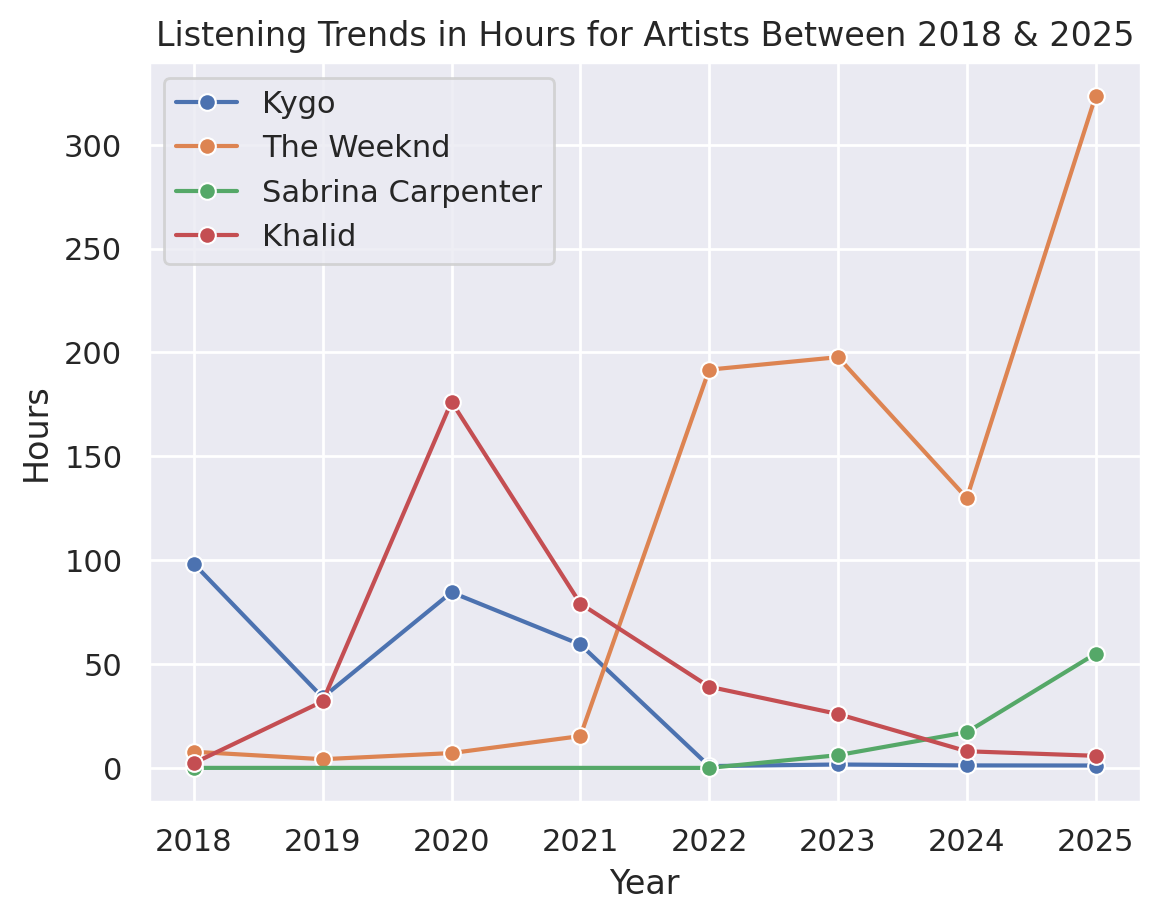

In [65]:
#Plotting listening trends for select artists between 2018 and 2025

over_the_years(2018, 2025, ["Kygo", "The Weeknd", "Sabrina Carpenter", "Khalid"]) #Calling the over_the_years function

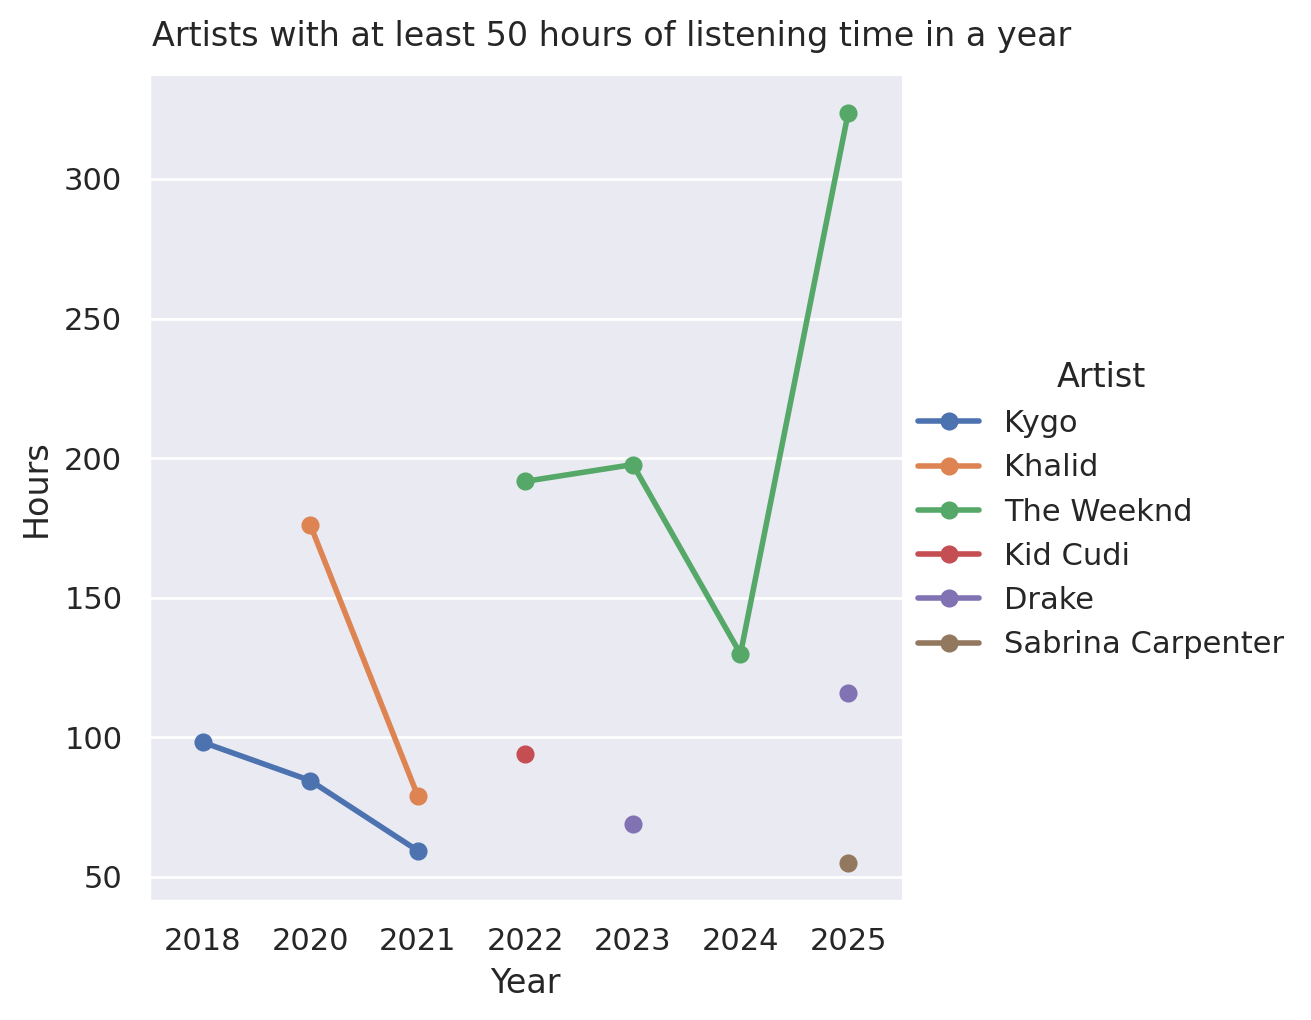

In [66]:
# Plotting artists with playtimes of at least 50 hours or more in a year

minimum = 50
c = sns.catplot(data=artist_years[artist_years["Hours"] >= minimum ], x="Year", y="Hours", hue="Artist", kind='point',linewidth=2)
c.fig.suptitle('Artists with at least {} hours of listening time in a year'.format(minimum), y=1.02, size=12)
sns.set_theme(style='darkgrid')
sns.color_palette(palette='Paired')
plt.show()

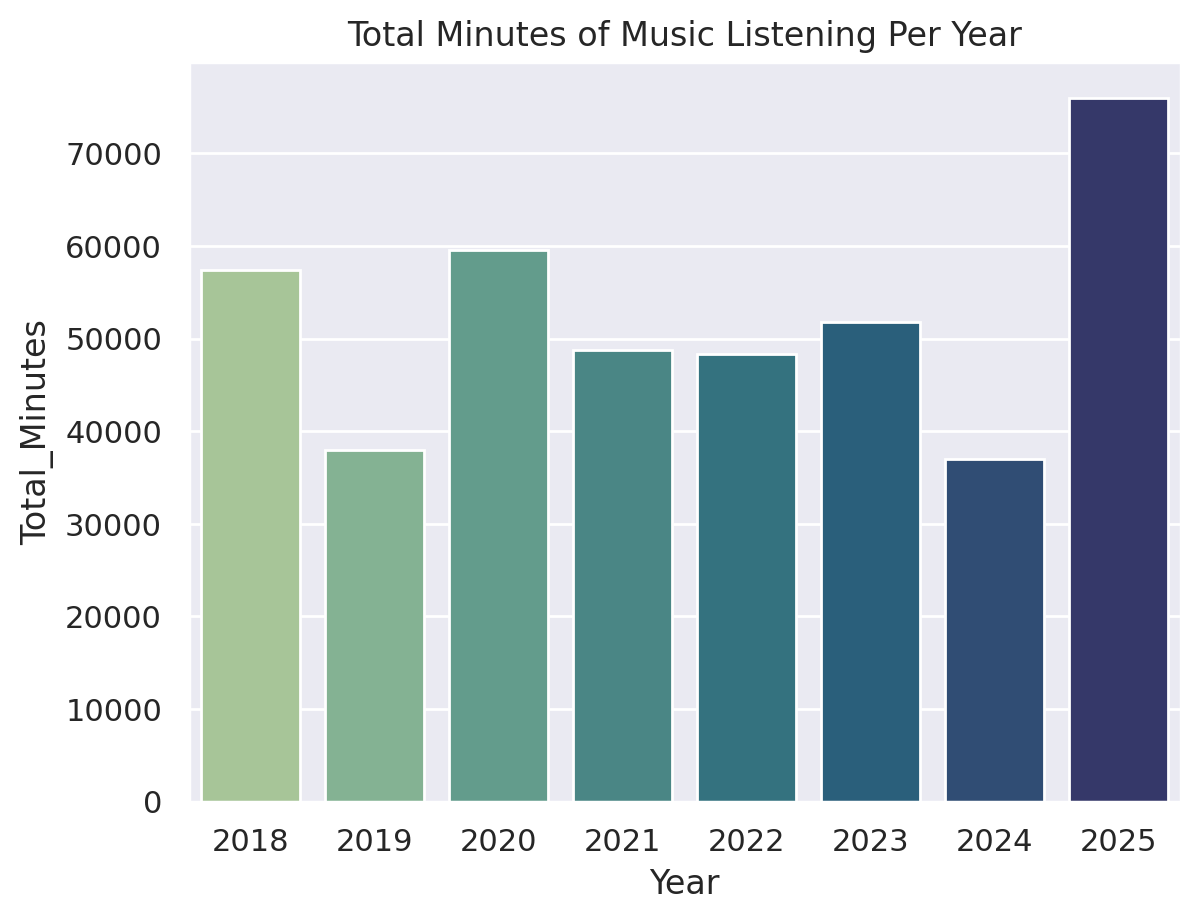

In [67]:
#Plotting Total Minutes of Music Listening Per Year

sns.barplot(x="Year", y='Total_Minutes', data=listening_by_year, hue='Year', legend=None, palette='crest')
plt.title("Total Minutes of Music Listening Per Year")
sns.set_theme(style='darkgrid')
plt.show()

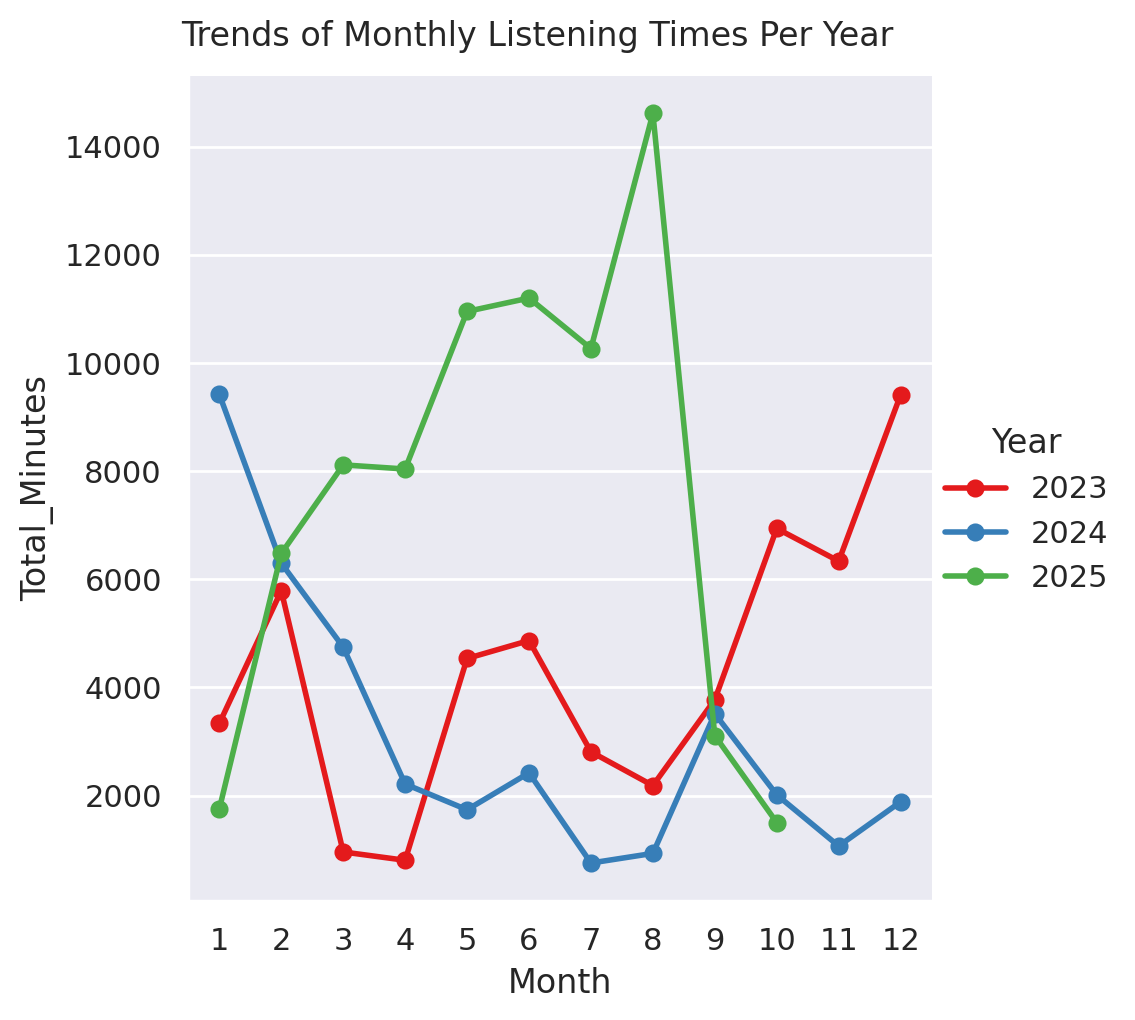

In [68]:
#Plotting Trends of Monthly Listening Times Per Year

d = sns.catplot(playtime_by_month[playtime_by_month["Year"] >= 2023], x="Month", y="Total_Minutes", hue="Year",
                kind="point", palette='Set1', linewidth=2)
d.fig.suptitle("Trends of Monthly Listening Times Per Year", y=1.02, size=12)
sns.set_theme(style='darkgrid')
plt.show()

### All Time Data

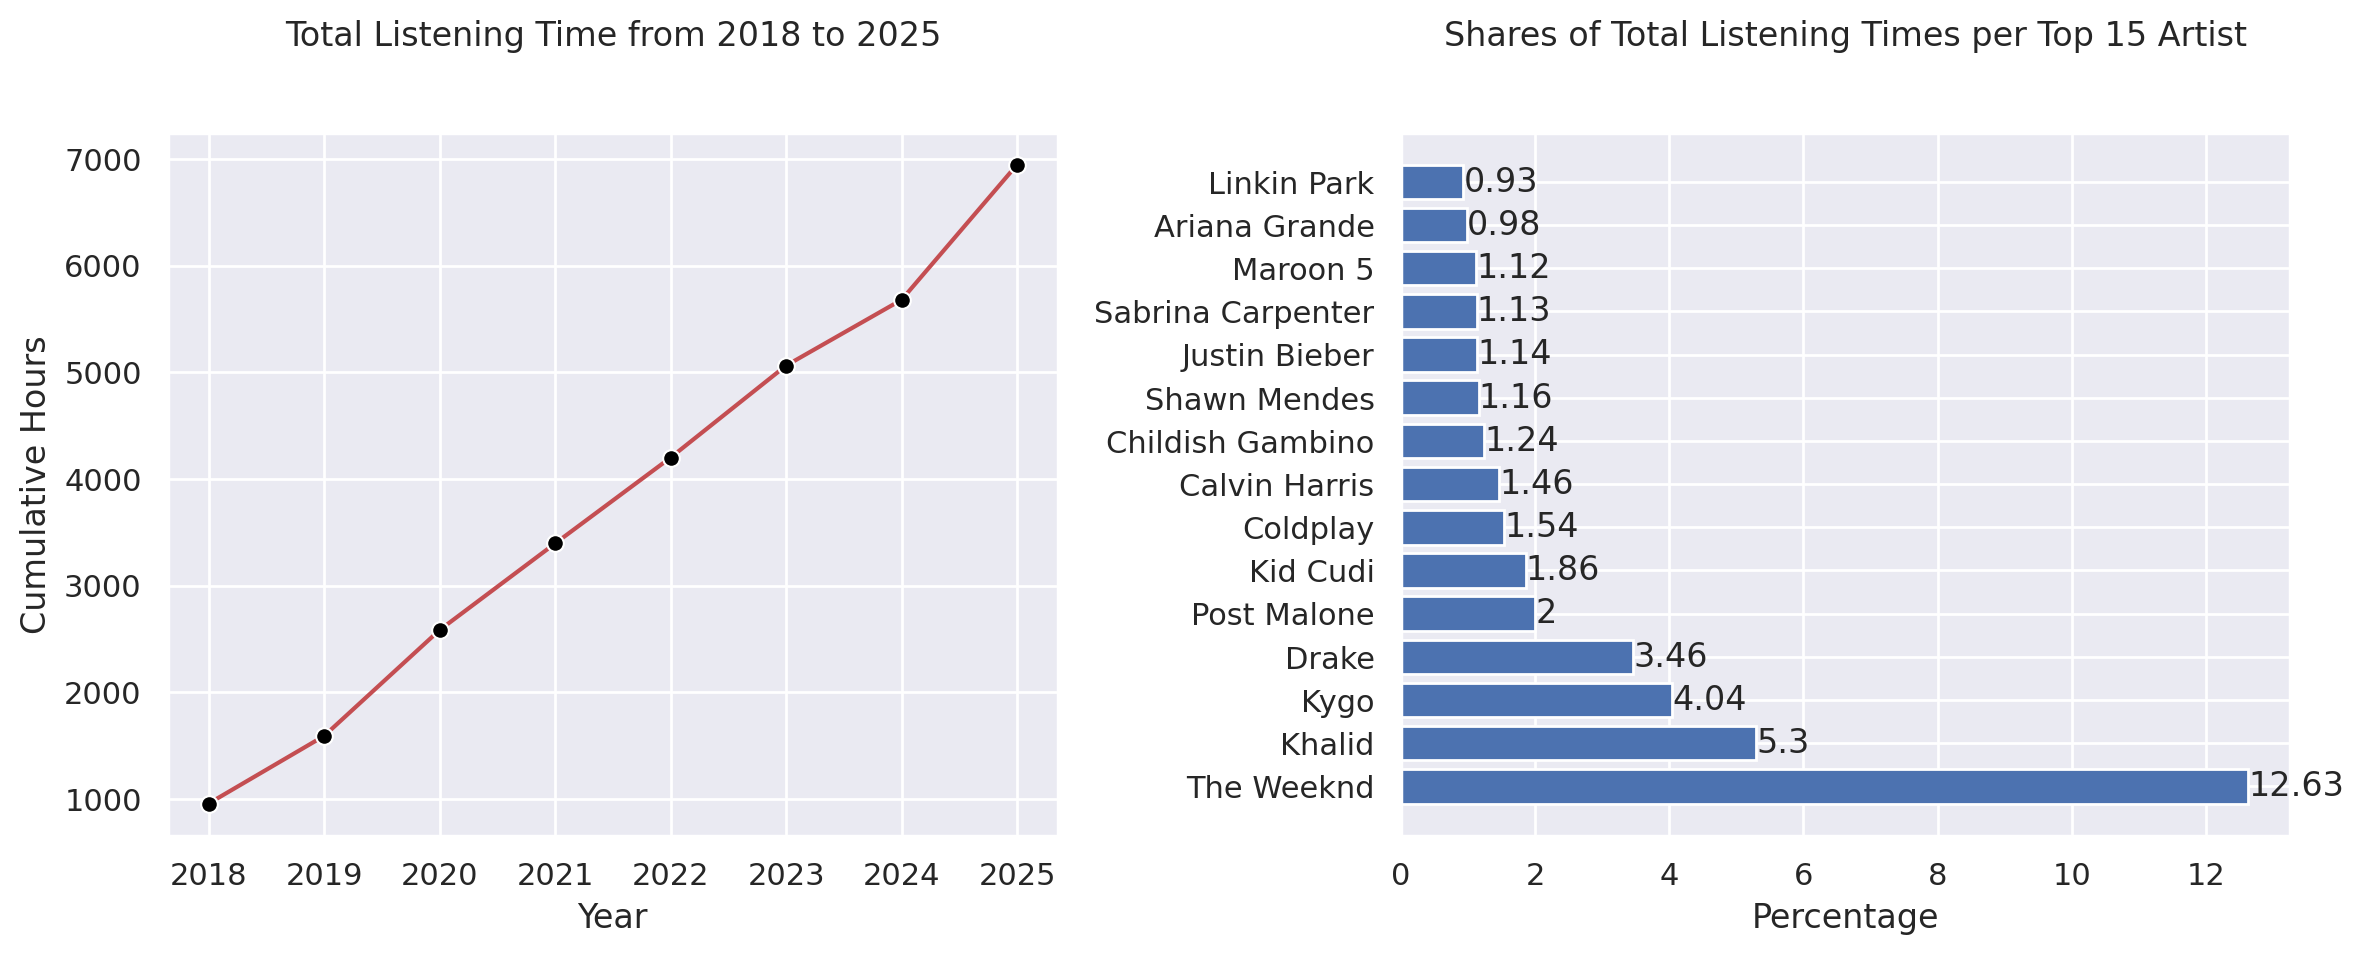

In [69]:
# Plotting the cumulative listening times over the years

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(data=listening_by_year, x="Year", y="Cumulative_Total_Hours", ax=axes[0], color='r', marker='o', markerfacecolor='black')
axes[0].set_title('Total Listening Time from {} to {}'.format(listening_by_year['Year'].min(), listening_by_year['Year'].max()), y=1.1)
axes[0].set_ylabel("Cumulative Hours")


bars = axes[1].barh(data=artist_total_hours_top15, y='Artist', width='Percentage of Total Hours')
axes[1].set_title('Shares of Total Listening Times per Top 15 Artist', y=1.1)
axes[1].set_xlabel('Percentage')
axes[1].bar_label(bars)

plt.tight_layout()
plt.show()

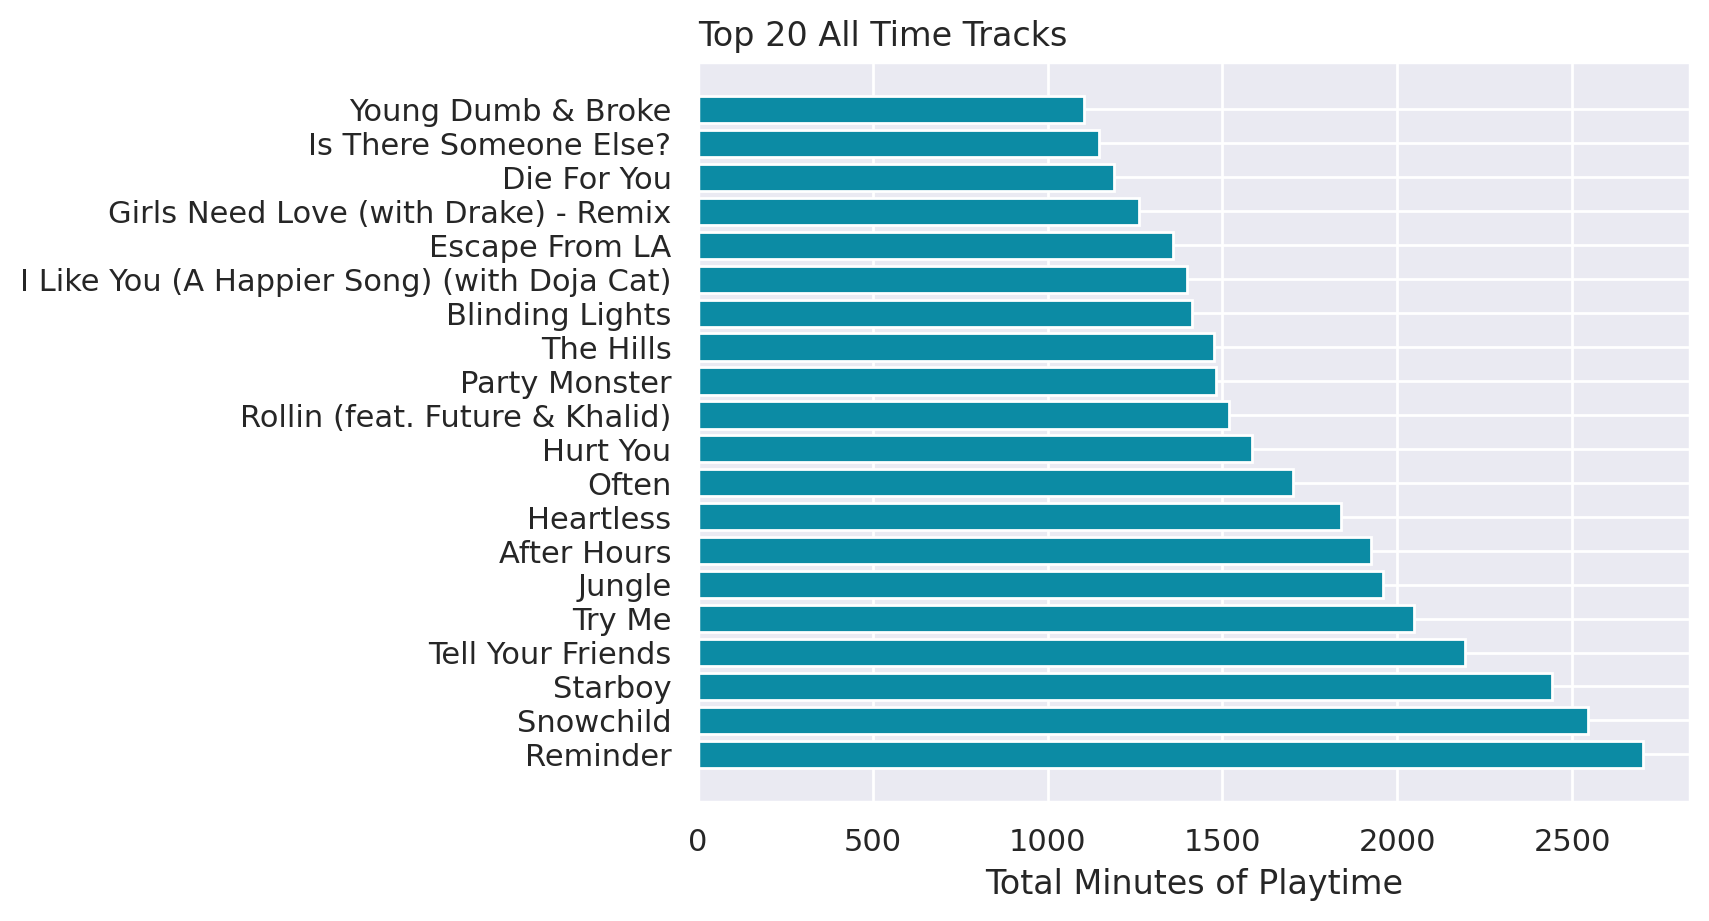

In [70]:
#Plotting the 20 of my most played songs since 2018 against their respecitve playtimes in minutes

plt.barh(data = num_of_unique_songs[0:20], y="Track_name", width = "Minutes_Played", color='#0c8ba4')
plt.title(f"Top {20} All Time Tracks ", loc='Left')
sns.set_style('darkgrid')
plt.xlabel("Total Minutes of Playtime")
plt.show()

In [71]:
end_time = time.time()
print("Execution time: ", end_time - start_time,"secs")

Execution time:  37.800426959991455 secs
